# <a id="dimreduction"></a>
# SelfLearning ML2 Part 1_v2.0

This notebook is adapted from FE et al. and corrected/edited by JN ( last update: April 2021).
This notebook is complementary to the lecture slides. It may serve you to find further reading, learn some keywords, or get a deeper understanding by just more examples and more things around the stuff, or from another perspective. You do not need to study this in order to be prepared for the exam. It is just a bit more meaty meaty.

## The curse of dimensionality


High dimensional data is more frequent than one might first think, e.g., even a low resolution  grey scale image from the famous [MNIST datase](https://en.wikipedia.org/wiki/MNIST_database):


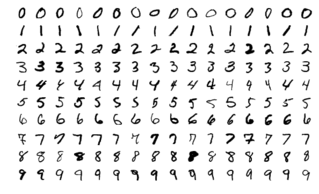


has 784 dimensions, as it contains intensity information for each of its $28\times 28 = 784$ pixels.

A high dimensional feature space is problematic for a number of reasons:

### Problems for visualization and exploration

Humans are simply not evolutionarily adapted to handle larger dimensional data well:
+ We are very good at recognizing patterns visually in 2 and 3 dimensional data, but we cannot really handle higher dimensional spaces.
+ A large number of our geometrical intuitions are not transferable to high dimensional spaces.

### Problems for ML algorithms 

+ For many supervised learning algorithms the number of examples needed to achieve a given level of accuracy grows exponentially with the number of dimensions (precision is proportional to data density in the feature space). 

+ More concretely, _distances_ in the feature space on which many ML algorithms  are based tend to be less and less discriminative as the number of dimensions grow.


### A few cautionary tales

Consider the following table, which shows the side length (also called linear dimension) of a hypercube that covers the given $f$ fraction of the volume of a $[0,1]^D$ unit hypercube for a number of $D$ dimensions ($\sqrt[D]{f}$):

In [1]:
import pandas as pd

dims = list(range(1,11))
fracs = [0.2, 0.01, 0.001,0.0001]
result = []
for frac in fracs:
    result.append([frac**(1/dim) for dim in dims])
pd.DataFrame(result, columns = ["f"] +[f"{dim} dims" for dim in dims[1:]])

,f,2 dims,3 dims,4 dims,5 dims,6 dims,7 dims,8 dims,9 dims,10 dims
0,0.2000,0.447214,0.584804,0.668740,0.724780,0.764724,0.794597,0.817765,0.836251,0.851340
1,0.0100,0.100000,0.215443,0.316228,0.398107,0.464159,0.517947,0.562341,0.599484,0.630957
2,0.0010,0.031623,0.100000,0.177828,0.251189,0.316228,0.372759,0.421697,0.464159,0.501187
3,0.0001,0.010000,0.046416,0.100000,0.158489,0.215443,0.268270,0.316228,0.359381,0.398107


#### Increasing sample requirements

The figures show that if we train an ML algorithm using one feature on the 20% of a population, and start adding new features (i.e., dimensions) then we need dramatically more samples to maintain the same amount of coverage on the feature space: concretely, even for 3 features we'd need almost 60% of the population:

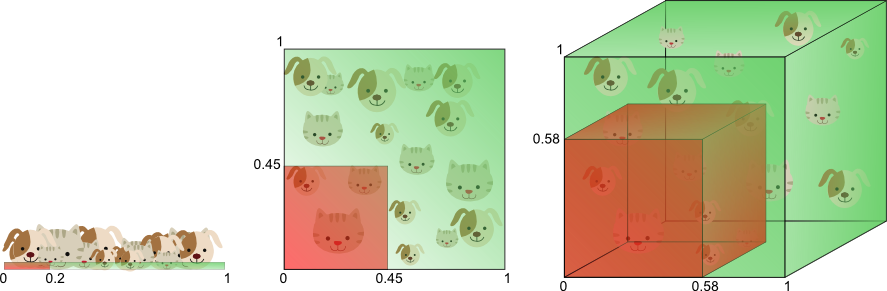

#### Problems with neighborhood-based methods

Let's suppose that using a KNN-like approach we predict the label of an input which is uniformly distributed in $[0,1]^D$ on the basis of the labels of examples in a small hypercube around it which contains an $f$- fraction of the examples. As the table shows, for $D=10$ dimensions and $f=0.01$ the "small" hypercube's size will be 0.63, that is, we will not really use _local_ information for determining the label at all. (The size is slightly more than 0.5 even for $f=0.001$.)

(The example is from Murphy, Machine Learning:  A probabilistic perspective (MIT, 2012))

#### Samples are pushed to the corners

Another strange effect of high dimensionality is that the ratio of normal/central examples that are close to the centroid of the population radically decreases, because of the strange behavior of hyperspheres. E.g., considering again an $[1,0]^D$ feature space and an edged hypersphere, the volume of the hypesphere, and consequently the ratio of central examples tends to 0 (even though the sphere touches all sides of the hypercube):

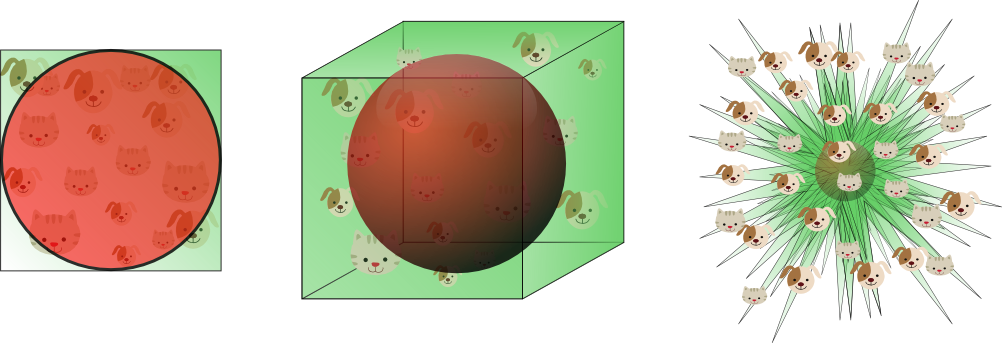


#### Does this mean that ML algorithms are hopeless already for ~10 features?

Fortunately, no -- notice that the cautionary tales all assumed that the data is more or less _uniformly distributed_ in the high-dimensional space. Frequently, this is not the case: to return to our MNIST example, even a cursory glance at the examples:

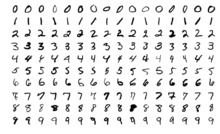

(Image source: [Wikipedia](https://en.wikipedia.org/wiki/MNIST_database))

shows that the data points are _not_ uniformly distributed in the 784 dimensional space, e.g., many positions are always white. The lesson is rather that high dimensional spaces can behave very counterintuitively, can cause problems for ML algorithms, and the clever exploitation of the data distribution (e.g., dense lower dimensional subspaces) is highly important for the performance of ML methods.

## Types of dimensionality reduction

### Feature selection/filtering
Decrease number of features by dropping less useful ones 
- e.g. some features might have information content that is contained in other featurs

Good indicators:
  - **high correlation** between pairs of features
  - **low information gain**  in terms of both featues vs. only one


### Feature projection
Replace certain or all features with a lower number of new ones, containing (most of) useful information of original feature 

Data points in the original feature space represented in a new feature space 
- New feature values are __projections__ of the data points onto the axes of the new space
- Concept of "projection" not necessarily linear


In [2]:
# Iris dataset
from sklearn import datasets

iris = datasets.load_iris()
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [3]:
# Data
import pandas as pd
import numpy as np

pd.DataFrame(data= np.c_[iris['data'], iris['target']], columns= iris['feature_names'] + ['target']).head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


<ipython-input-4-03d594980959>:8: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig, elev=-150, azim=110)


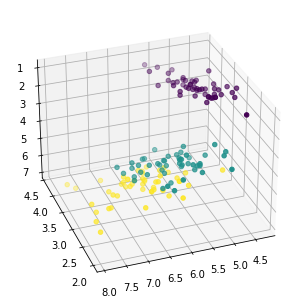

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

X = iris.data[:, :4]  # we only take the first two features.
Y = iris.target

fig = plt.figure()
ax = Axes3D(fig, elev=-150, azim=110)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=Y)

plt.show()

<ipython-input-5-f82c0cee0060>:2: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig, elev=-150, azim=110)


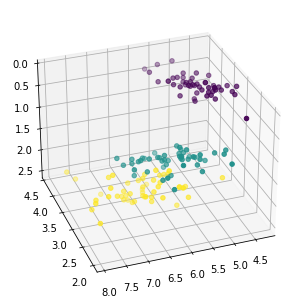

In [5]:
fig = plt.figure()
ax = Axes3D(fig, elev=-150, azim=110)
ax.scatter(X[:, 0], X[:, 1], X[:, 3], c=Y)

plt.show()

<ipython-input-6-3e595cf392d7>:2: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig, elev=-150, azim=110)


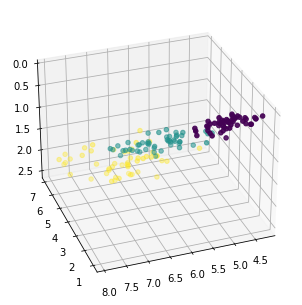

In [6]:
fig = plt.figure()
ax = Axes3D(fig, elev=-150, azim=110)
ax.scatter(X[:, 0], X[:, 2], X[:, 3], c=Y)

plt.show()

<ipython-input-7-85a4646a6591>:2: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig, elev=-150, azim=110)


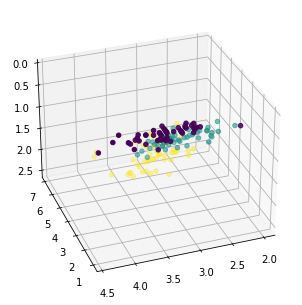

In [7]:
fig = plt.figure()
ax = Axes3D(fig, elev=-150, azim=110)
ax.scatter(X[:, 1], X[:, 2], X[:, 3], c=Y)

plt.show()

## Feature projection methods

## Linear methods

- Transformation into new feature space linear
- Find new and more useful axes that can be expressed as linear combinations of basis vectors of  old feature space

### Principal Component Analysis (PCA)

- One of the most important linear dimension reduction methods for continuous features
- Finds set of orthogonal directions in the old feature space along which the variance of the data is the largest 
-> Minimizes the covariance of the data between the new directions.

The **variance** of an $A=\{a,\dots,a_{N}\}$ of a data set can be defined here as

$$
\sigma^2_A=\frac{1}{N-1}\sum_i (a_i - \bar{a})^2
$$

and the **covariance** of values $A=\{a_1,\dots,a_{N}\}$ and $B=\{b_1,\dots,b_{N}\}$ is 

$$
\sigma^2_{AB}=\frac{1}{N-1}\sum_i (a_i - \bar{a})(b_i - \bar{b})
$$

where $\bar a$ and $\bar b$ signify the means of $A$ and $B$, respectively.

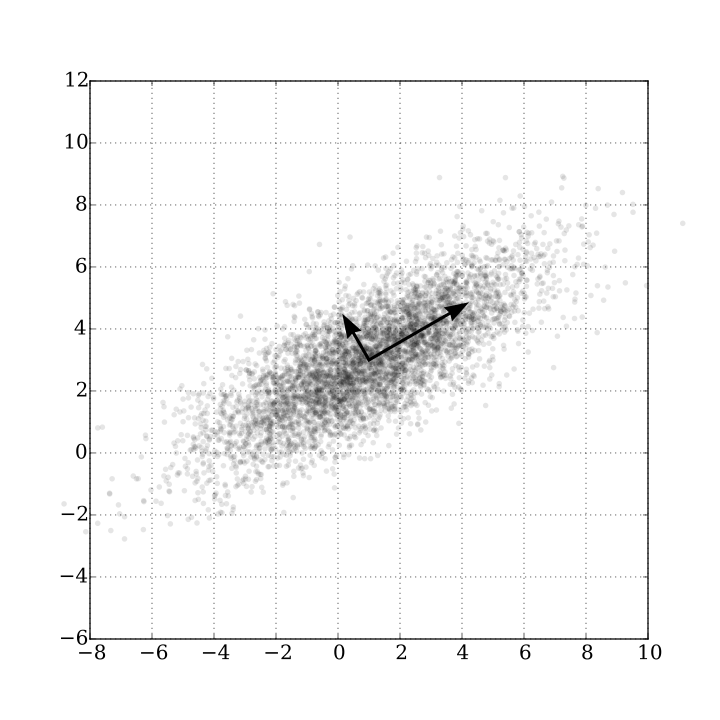


([source](https://en.wikipedia.org/wiki/Principal_component_analysis))


- **High variance along axes** ensures that new features have high information content
- **Low covariance between projections (guaranteed by orthogonality) onto the new axes** means that none of the new features contain  highly correlated information







#### Intuitive algorithm
1.  Find a direction in the feature space along which variance is maximal. This will be the first new basis vector (principal component).

2.  Find  another  direction  along  which  variance  is  maximized and which is orthogonal to all basis vectors found so far.

3.  Repeat Step 2 until all $m$ vectors of the basis are found.


#### Using PCA for dimension reduction
- New basis vectors PCA produces are ordered by variance
- Drop components with low variance, because they can be considered to be (mainly) noise 

<a href="http://www.nlpca.org/fig_pca_principal_component_analysis.png"><img src="https://drive.google.com/uc?export=view&id=1T-LhhvX6jv9UO07RO29DpkQ3la9iWUoG"></a>

(source: http://nlpca.org)

#### PCA diagonalizes the covariance matrix  (details and link to Linear Alegbra & EV factorization as given in lecture)

- Mathematically, PCA's finds new orthonormal basis  in which the __covariance matrix__  of the data is diagonal (all non-diagonal elements are 0). 
- Covariance matrix for a dataset $\mathbf X=\{\mathbf x_1,\dots, \mathbf x_N\}$ of $m$-dimensional vectors with data for features $F_1,\dots,F_{m}$ is the matrix 

$$ \text{Cov}(\mathbf X) = \frac{1}{N-1}\sum_{i=1}^N(\mathbf x_i-\bar{\mathbf x})(\mathbf x_i-\bar{\mathbf x})^T=
\begin{bmatrix}
\sigma^2_{F_1} &\cdots &\sigma^2_{F_1 F_{m}}\\
\vdots & \ddots & \vdots \\
\sigma^2_{F_m F_{1}} & \cdots & \sigma^2_{F_m}
\end{bmatrix}
$$
that is, for each cell in row $i$ and column $j$ it contains the covariance of $F_i$ and $F_j$ -- consequently  the diagonal of the matrix contains the _variances_ of the data for each feature.

In [8]:
import pandas as pd
from sklearn.datasets import make_blobs
from numpy import mean
from numpy import std
from numpy.random import randn
from numpy.random import seed
from numpy import cov
from scipy.stats import pearsonr 
from matplotlib import pyplot
from matplotlib.colors import ListedColormap
import sympy as sympy
import numpy as np
from scipy import *
import matplotlib.pyplot as plt 
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from IPython.display import display, Math, Latex
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

<ipython-input-9-b6cc7f44486c>:11: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig, elev=-150, azim=110)
<ipython-input-9-b6cc7f44486c>:19: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig, elev=-150, azim=110)


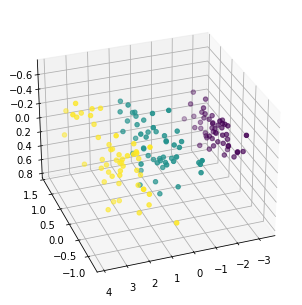

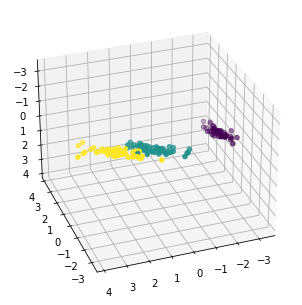

In [9]:
# Plot, 3D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
X_plane = pca.inverse_transform(X_pca)

pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)
X_pca_plane = pca.fit_transform(X_plane)

fig = plt.figure(1)
ax = Axes3D(fig, elev=-150, azim=110)
ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=Y)

xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_xlim()
zmin, zmax = ax.get_xlim()

fig = plt.figure(2)
ax = Axes3D(fig, elev=-150, azim=110)
ax.set_xlim(xmin,xmax)
ax.set_ylim(ymin,ymax)
ax.set_zlim(zmin,zmax)
ax.scatter(X_pca_plane[:, 0], X_pca_plane[:, 1], X_pca_plane[:, 2], c=Y)

plt.show()

#### Explained variance by component

- When we switch to new feature space produced by PCA, say from features $F_1, \dots, F_m$ to $P_1,\dots, P_m$  _total variance_ of our data, which is the sum of the variances along the features remains unchanged (given no components are dropped):

$$
\sum_i\sigma^2_{F_i}=\sum_i\sigma^2_{P_i}
$$

- Only distribution of total variance among features changes. 
- Accordingly, makes sense to talk about how much of the total variance of the data is along ("explained by") a PCA component/feature $P_k$: this value is simply $$\frac{\sigma^2_{P_k}}{\sum_i\sigma^2_{P_i}}$$.

Customary to use the "explained variance" percentage of components to decide which one can be omitted to reduce dimensionality.

Note here that in the lecture we use the EVs instead of the variances to define the variance explained ratio, because of the covariance decomposition, $\Sigma=S \Lambda S^{-1}$. The notions are equivalent.

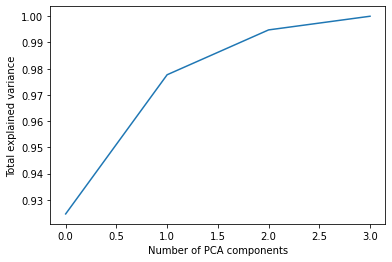

In [10]:
# Decreasing variance
pca = PCA().fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of PCA components')
plt.ylabel('Total explained variance')
plt.show()

#### Reconstructing the original representation from the PCA representation

- Mapping from old feature space to new provided by PCA can be reversed 
- Using the PCA components and the new representations the original data can be reconstructed, at least approximately:

<a href="http://alexhwilliams.info/itsneuronalblog/img/pca/rank_one.png"><img src="https://drive.google.com/uc?export=view&id=1wheGkUUxAic4c2gwJ6Xj5IMKtpCyr5BE" width="900"></a>

- As more and more components are used the approximation gets more precise 
- Using all components we are guaranteed to get back exactly the original data 
- Otherwise data points replaced with their projections on the subspace determined by chosen components


<a href="http://alexhwilliams.info/itsneuronalblog/img/pca/pca_3.png"><img src= "https://drive.google.com/uc?export=view&id=1TN302dZz31WZz2cEaj7VJOdDDt1xhpAq" width="900"></a>

(source: [Everything you did and didn't know about PCA](http://alexhwilliams.info/itsneuronalblog/2016/03/27/pca/))


In [11]:
from sklearn.datasets import load_digits
digits = load_digits()
print(digits.DESCR)

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 1797
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each blo

In [68]:
digits.data.shape

(1797, 64)

In [69]:
X = digits.data
pca = PCA(2)  # project from 64 to 2 dimensions
X_pca = pca.fit_transform(X)
print(X.shape)
print(X_pca.shape)

(1797, 64)
(1797, 2)


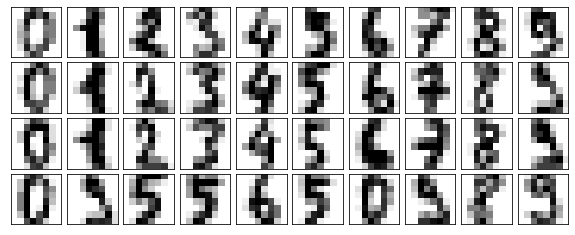

In [70]:
def plot_digits(data):
    fig, axes = plt.subplots(4, 10, figsize=(10, 4),
                             subplot_kw={'xticks':[], 'yticks':[]},
                             gridspec_kw=dict(hspace=0.1, wspace=0.1))
    for i, ax in enumerate(axes.flat):
        ax.imshow(data[i].reshape(8, 8),
                  cmap='binary', interpolation='nearest',
                  clim=(0, 16))
    plt.show()
plot_digits(X)

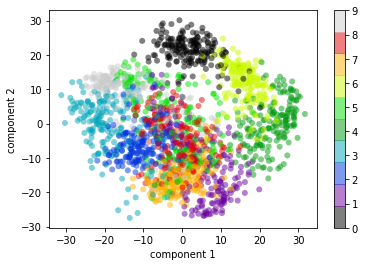

In [71]:
plt.scatter(X_pca[:, 0], X_pca[:, 1],
            c=digits.target, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();
plt.show()

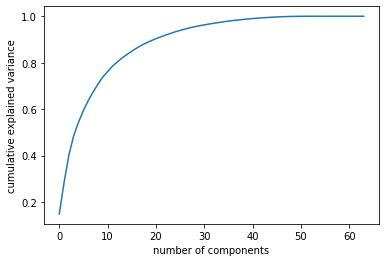

In [72]:
pca = PCA().fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.show()

In [73]:
# here the minium variance is specified as 0.90
# which determines the number of components=21 (alternative usage of PCA)
pca = PCA(0.90).fit(digits.data)  
print(pca.n_components_)

21


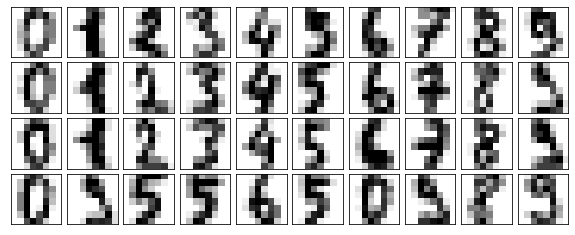

In [77]:
#generate Gaussian noise with data=mean and std=4 (for comparison)
np.random.seed(42)
noisy = np.random.normal(X, 4)
plot_digits(noisy)

In [44]:
pca5 = PCA(0.50).fit(X) #only 50% of variance is represented
print(pca5.n_components)

0.5


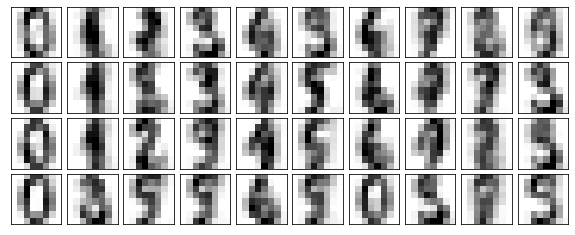

In [45]:
components = pca5.transform(noisy) #looks like the "noised" one before
filtered = pca5.inverse_transform(components)
plot_digits(filtered)

In [46]:
del digits #sometimes saves the CPU

In [47]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


In [48]:
pca = PCA(150, svd_solver='randomized')
pca.fit(faces.data)

PCA(n_components=150, svd_solver='randomized')

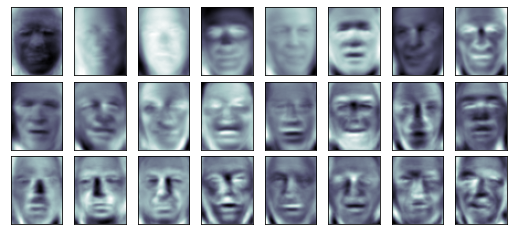

In [49]:
fig, axes = plt.subplots(3, 8, figsize=(9, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(pca.components_[i].reshape(62, 47), cmap='bone')
    
plt.show()

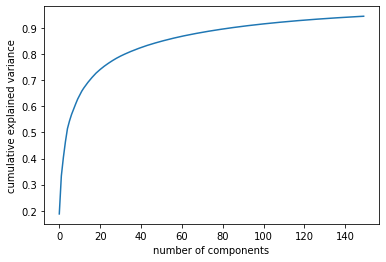

In [50]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.show()

In [51]:
components = pca.transform(faces.data)
projected = pca.inverse_transform(components)

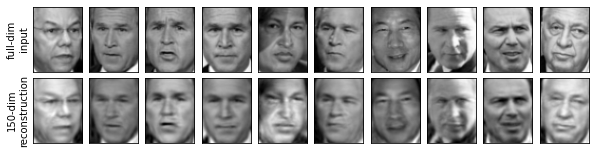

In [52]:
fig, ax = plt.subplots(2, 10, figsize=(10, 2.5),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i in range(10):
    ax[0, i].imshow(faces.data[i].reshape(62, 47), cmap='binary_r')
    ax[1, i].imshow(projected[i].reshape(62, 47), cmap='binary_r')
    
ax[0, 0].set_ylabel('full-dim\ninput')
ax[1, 0].set_ylabel('150-dim\nreconstruction');

plt.show()

#### Further reading
+ [A very good technical PCA tutorial by Jonathon Shlens](https://arxiv.org/abs/1404.1100)

### Sparse PCA

- Disadvantage of PCA: difficult to interpret results, since produced new features typically linear combinations of _all_ original features
- Sparse PCA tries to solve problem by trying to find components which maximize variance but are sparse in the sense that they combine a low number features 

+ Sparsity is typically implemented in the objective function as an L1 penalty.
+ The orthogonality requirement of PCA is dropped.
+ Because of the L1 penalty and the connection between variance maximization and LSE (least square error) minimization problem closely related to LASSO linear regression, and is solved with similar methods

We will introduce regularization such as L1 and L2 later in the lecture

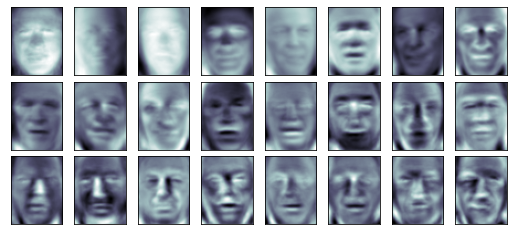

In [53]:
from sklearn.decomposition import SparsePCA
sparsePca = SparsePCA(n_components=64, alpha=0, ridge_alpha=1e-6, max_iter=200, tol=1e-3)
sparsePca.fit(faces.data)

fig, axes = plt.subplots(3, 8, figsize=(9, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(sparsePca.components_[i].reshape(62, 47), cmap='bone')
    
plt.show()

#### Further reading

An introduction to PCA and its sparse variants:
[Everything you did and didn't know about PCA](http://alexhwilliams.info/itsneuronalblog/2016/03/27/pca/)


### Non-negative Matrix Factorization (NMF)

- Even if all values in original data non-negative, PCA and its variants frequently produce components and new representations with _negative values_
- Often undesirable: component subtraction difficult to interpret

Technically, NMF

- Solves the factorization problem $X \approx W \times H$ where $X$ is the input data matrix, $W$ is the new representation and $H$ is the component ("hidden factor") matrix.
- Often used in conjunction with sparsity inducing regularization (e.g., L1 and L2).
- The objective is to minimize the reconstruction error $||X-WH||^2_F$
- The factorization is not unique, since if $B$ is invertible and $B$ and $B^{-1}$ are non-negative then $W\times H =WB\times B^{-1}H$ is also solution.



#### PCA vs NMF:

(red squares represent negative values)

<a href="http://drive.google.com/uc?export=view&id=15c9GUhTki91dujRIrfiUpHvHzxpyXYjO"><img src="https://drive.google.com/uc?export=view&id=13ajGXC2sOZwFRFH4SXPLcoKbhZMPs1-X"></a>

<a href="http://drive.google.com/uc?export=view&id=1AuQw9YU2QbZ8GuP5CS-zZZzARW-j9uzN"><img src="https://drive.google.com/uc?export=view&id=1VRpj1z-NbCakl9fQjvXJDjvZdK2bvjf_"></a>

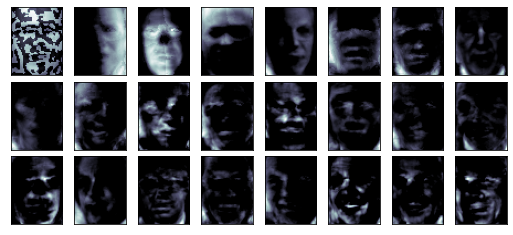

In [54]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)

from sklearn.decomposition import NMF
nmf = NMF(n_components=150, init='nndsvda', tol=5e-3)
nmf.fit(faces.data)

fig, axes = plt.subplots(3, 8, figsize=(9, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(nmf.components_[i].reshape(62, 47), cmap='bone')
    
plt.show()

### Linear Discriminant Analysis (LDA)

- PCA, which is an "unsupervised" method in the sense that it does not make use of a distinction of input and output variables/features (e.g. data to be classified and the correct class labels),
- LDA can be used for classified data points to find directions/components in the feature space that have good classificatory properties

#### LDA objective

Goal of LDA to find (not necessarily orthogonal) directions in the feature space which simultaneously

- maximise the distances between the means of the classes
- minimise the variance within the classes

Number of new dimensions produced by LDA depends on the number of classes and the dimensionality of original feature space: 
- for $m$ classes and $n$ original features can produce a $\min(m-1, n)$ dimensional new feature space

##### For binary classification

For a binary classification problem LDA seeks a _single_ axis in the feature space which maximizes the following value:

$$\frac{(\tilde{\mu_1}-\tilde{\mu_2})^2}{\tilde{\sigma_1}^2+\tilde{\sigma_2}^2} $$

where $\tilde{\mu_1}$ and $\tilde{\mu_2}$ are the projections of the two class centroids on the axis, and $\tilde{\sigma_1}^2$ and $\tilde{\sigma_2}^2$ are the _variances_ of the data points of the two classes along the axis.


<a href="https://i.stack.imgur.com/2A4bb.jpg"><img src="https://drive.google.com/uc?export=view&id=1stdcEkCHD2L8_K2nxSiOnzstmQK0KlKo"></a>

(source: [Stack Exchange](https://stats.stackexchange.com/questions/161362/supervised-dimensionality-reduction), original source: [UCLA Stat 101 page](http://www.stat.ucla.edu/~ybzhao/teaching/stat101c/)


##### Generalization for multiclass classification (can be jumped)

For $m>2$  classes the projections are no longer scalar, so in this case both the separation between the means of the classes and the within the class variances are represented as so called _scatter matrices_. For a given $c$ class containing the $\mathbf X_c = \{\mathbf x_1,\dots,\mathbf x_N\}$ data points with $\bar{\mathbf x}_c$ mean the _within class scatter matrix_ is

$$S_w^c=\sum_{i=1}^N(\mathbf x_i-\bar{\mathbf x}_c)(\mathbf x_i-\bar{\mathbf x}_c)^T=N~\text{Cov}(\mathbf{X}_c)$$

while the _between classes scatter matrix_ for $c$ is

$$S_b^c=N(\bar{\mathbf x}_c-\bar{\mathbf x})(\bar{\mathbf x}_c-\bar{\mathbf x})^T$$

where $\bar{\mathbf x}$ is the mean of the whole dataset. With these definitions the LDA goal for $C=\{c_1,\dots,c_m\}$ classes is to find $m-1$ axes in the original feature space for which the scatter matrices of the data points' projections maximize

$$\frac{|\sum_{c\in C} S_b^c|}{|\sum_{c\in C} S_w^c|}$$

where the $|\cdot|$ matrix operator used to get scalar values for the nominator and denominator takes the determinant of the scatter matrixes providing a  kind of "sum total scatter".

<a href="https://i.stack.imgur.com/x1wle.jpg"><img src="https://drive.google.com/uc?export=view&id=1N1xNiiftzSOXgcci22MzaK6gR0Qnm160"></a>

(source: [StackExchange](https://stats.stackexchange.com/questions/22884/how-does-linear-discriminant-analysis-reduce-the-dimensions))

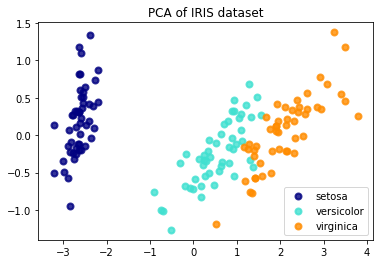

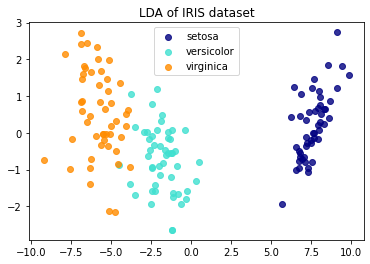

In [55]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

iris = datasets.load_iris()

X = iris.data
y = iris.target
target_names = iris.target_names

pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

lda = LinearDiscriminantAnalysis(n_components=2)
X_r2 = lda.fit(X, y).transform(X)

plt.figure(1)
colors = ['navy', 'turquoise', 'darkorange']
lw = 2

for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of IRIS dataset')

plt.figure(2)
for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(X_r2[y == i, 0], X_r2[y == i, 1], alpha=.8, color=color,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('LDA of IRIS dataset')

plt.show()

#### Further reading

[Tharwat, Alaa, et al. "Linear discriminant analysis: A detailed tutorial." AI communications 30.2 (2017)](https://www.researchgate.net/publication/316994943_Linear_discriminant_analysis_A_detailed_tutorial)

In [ ]:
#passed w/o error April 14, 2021